# Сегментация гор и неба

### Code

In [27]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

img = imread('rock.jpg')

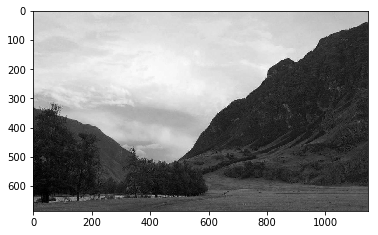

In [28]:
def brightness(img):
    """
    Подсчет яркости изображения.
    
    @param img numpy array  изображение
    @return numpy array     (yij), где yij - яркость пикселя img[i, j]
    """
    return (0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2]).astype(np.float64)

plt.imshow(brightness(img), cmap = 'gray')

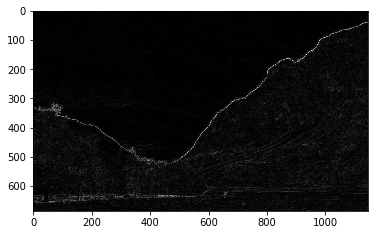

In [30]:
def energy_function(img):
    """
    Функция считает энергию (градиент) всех пикселей изображения img
    
    @param img numpy array  изображение
    @return numpy array     (Eij), где Eij - энергия пикселя img[i, j]
    """
    Y = brightness(img)
    ker_x = [[0., 0., 0.],
             [1., 0., -1.],
             [0., 0., 0.]]
    ker_y = [[0., 1., 0.],
             [0., 0., 0.],
             [0., -1., 0.]]
    I_x = scipy.signal.convolve2d(Y, ker_x, boundary='symm', mode='same')
    I_y = scipy.signal.convolve2d(Y, ker_y, boundary='symm', mode='same')
    
    return np.sqrt(I_x * I_x + I_y * I_y).astype(np.float64)

plt.imshow(energy_function(img), cmap='gray')

In [31]:
def find_vertical_seam(img):
    """
    Нахождение вертикального шва с минимальной энергией из img.
    
    @param img numpy array  изображение
    @return numpy array     маска шва
    """
    dp = np.zeros((img.shape[0], img.shape[1]), dtype='float64')
    prev = np.zeros((img.shape[0], img.shape[1]), dtype='int8')

    energy = energy_function(img)

    dp[0, :] = energy[0, :]

    height, width = energy.shape
    for y in range(1, height):
        for x in range(0, width):
            shift = dp[y - 1, max(0, x - 2):min(width, x + 3)].argmax() \
            - (0 if x - 1 < 0 else 1) - (0 if x - 1 < 0 else 1)
            dp[y][x] = dp[y - 1][x + shift] + energy[y][x]
            prev[y][x] = shift

    cur_position = [height - 1, 0]
    lowest_energy = dp[height - 1, 0]
    for x in range(1, width):
        if lowest_energy < dp[height - 1, x]:
            cur_position[1] = x
            lowest_energy = dp[height - 1, x]

    seam_mask = np.zeros((height, width), dtype='int8')
    y, x = cur_position
    seam_mask[y, x] = 1
    while cur_position[0] > 0:
        cur_position[0] += -1
        cur_position[1] += prev[y, x]
        y, x = cur_position
        seam_mask[y, x] = 1
        
    return seam_mask

def vizualization(img, only_seam=False):
    """
    Отображение сегментированной картинки. Разделяет горы от неба.
    
    @param img numpy array  изображение
    @param only_seam bool   отображать только шов
    """
    transp = (img[:, :, 0].transpose(),
              img[:, :, 1].transpose(), img[:, :, 2].transpose())
    t_img = np.stack(transp, axis=-1)
    
    seam_mask = find_vertical_seam(t_img)
    height, width, _ = t_img.shape

    for i in range(height):
        rock_filter = False 
        for j in range(width):
            if not rock_filter and seam_mask[i][j]:
                t_img[i, j] = (255, 0, 0)
                t_img[i - 1, j] = (255, 0, 0)
                rock_filter = True
            elif only_seam:
                if t_img[i, j][0] != 255 or t_img[i, j][1] != 0 or t_img[i, j][2] != 0:
                    t_img[i, j] = (0, 0, 0)
            elif rock_filter:
                t_img[i, j][1] = np.clip(t_img[i, j][1] + 50, 0, 255) 
            else:
                t_img[i, j][0] = np.clip(t_img[i, j][0] + 50, 0, 255)
                
    out = (t_img[:, :, 0].transpose(), t_img[:, :, 1].transpose(), t_img[:, :, 2].transpose())
    
    plt.figure(figsize=(20, 20))
    plt.imshow(np.stack(out, axis=-1))

### Пример работы

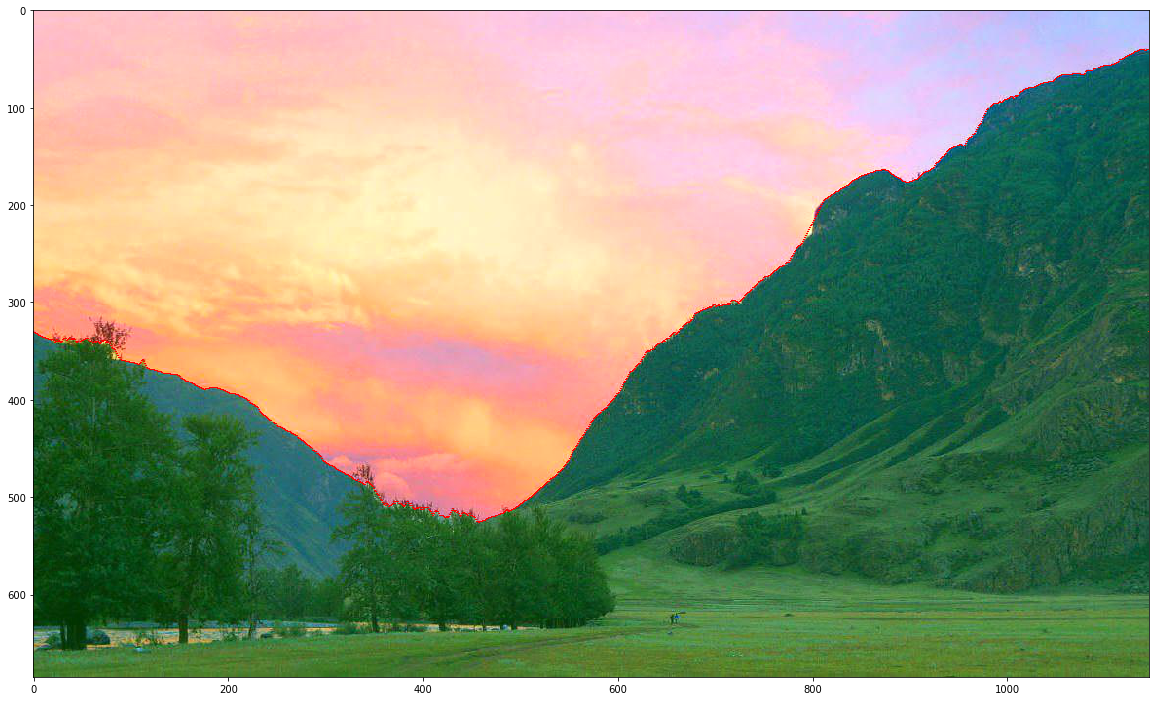

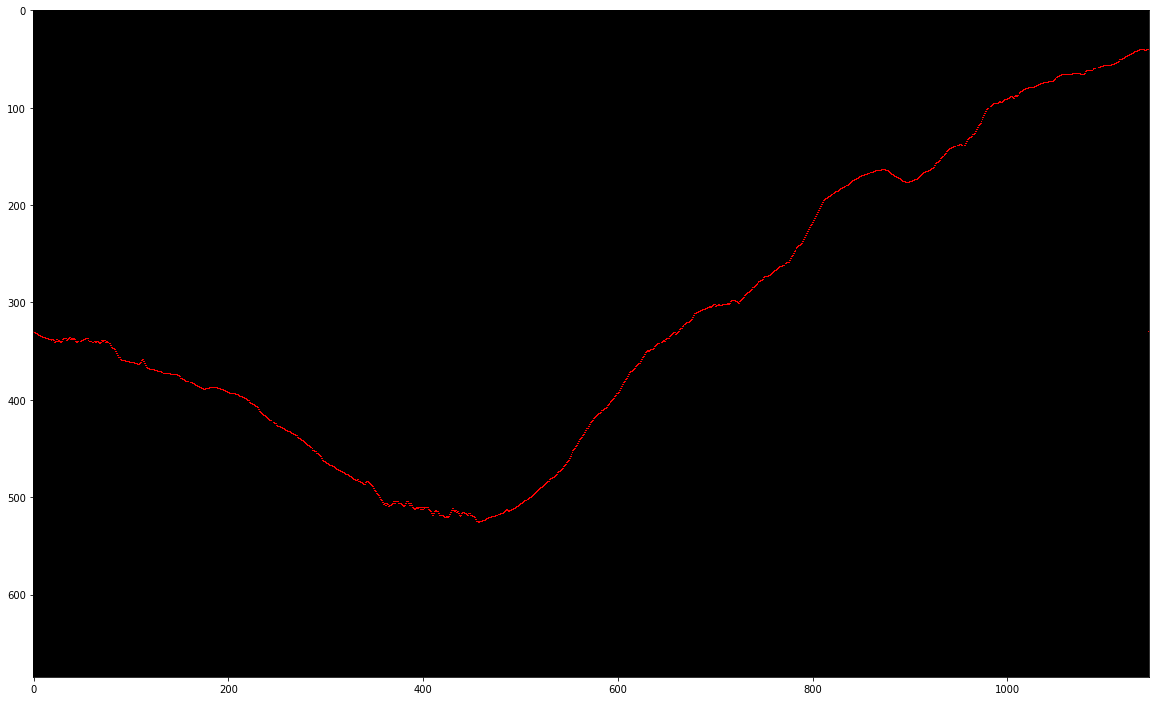

In [32]:
vizualization(img, only_seam=False)
vizualization(img, only_seam=True)

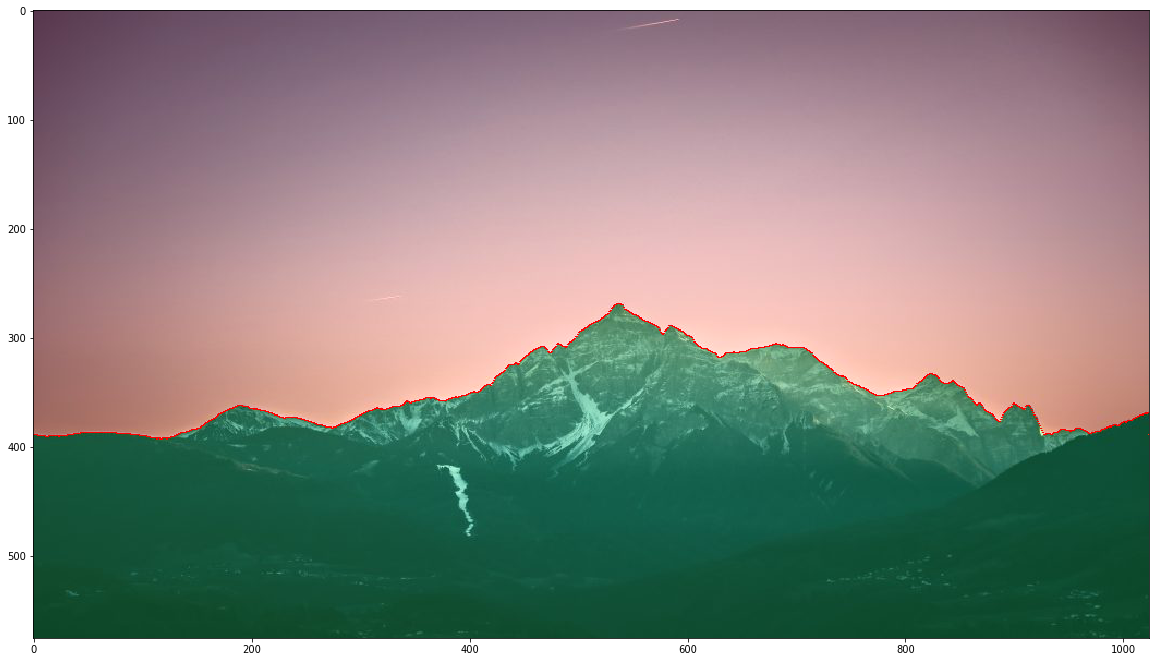

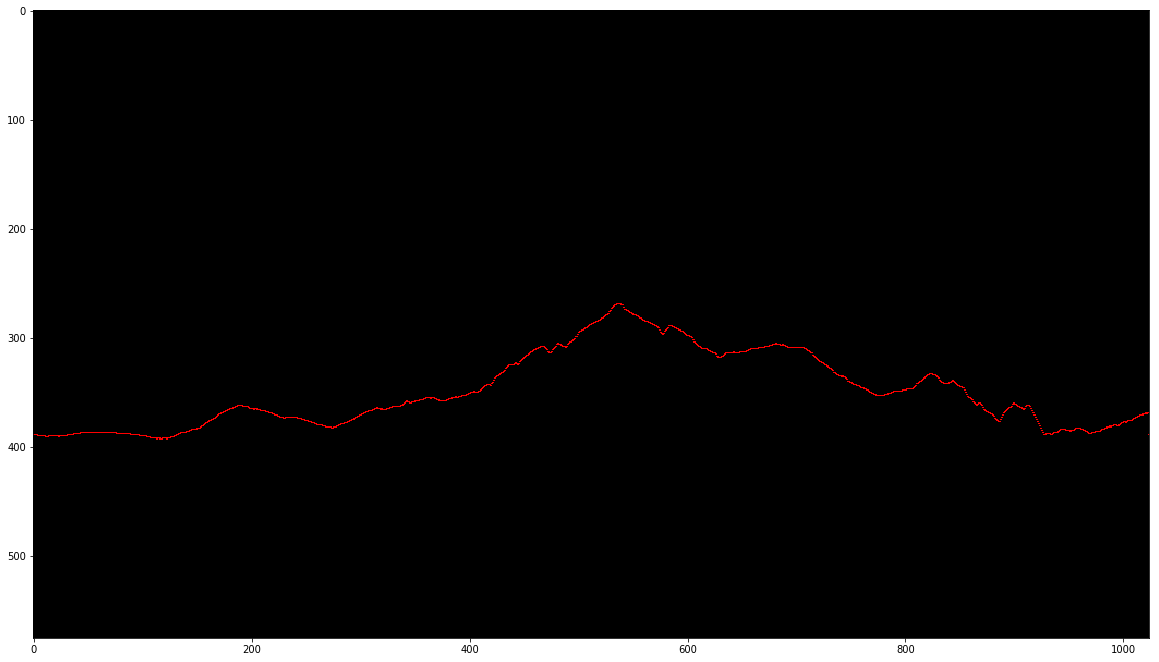

In [33]:
img = imread('rock2.jpg')
vizualization(img, only_seam=False)
vizualization(img, only_seam=True)